# ロバスト回帰
外れ値があるようなデータに直線モデルを適応させる．  
繰り返し最小二乗アルゴリズムを使ったフーバー回帰，テューキー回帰を実装．  

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# データ生成
np.random.seed(1)
def generate_sample(x_min=-3., x_max=3., sample_size=10):
    x = np.linspace(x_min, x_max, num=sample_size)
    y = x + np.random.normal(loc=0., scale=.2, size=sample_size)
    # y[-1] = -4   # outlier
    y[-1] = y[-2] = y[1] = -4   # outliers
    return x, y

In [3]:
def build_design_matrix(x):
    phi = np.empty(x.shape + (2,))
    phi[:, 0] = 1.
    phi[:, 1] = x
    return phi

In [4]:
# 繰り返し最小二乗アルゴリズム
def iterative_reweighted_least_squares(x, y, method='huber', eta=1., n_iter=1000):
    phi = build_design_matrix(x)
    # theta = theta_prev = np.random.rand(2)
    # initialize theta using the solution of regularized ridge regression
    theta = theta_prev = np.linalg.solve(phi.T.dot(phi) + 1e-4 * np.identity(phi.shape[1]), phi.T.dot(y))
    
    for _ in range(n_iter):
        # フーバー回帰
        if method == 'huber':
            r = np.abs(phi.dot(theta_prev) - y)
            w = np.diag(np.where(r > eta, eta / r, 1.))
        
        #テューキー回帰
        if method == 'tukey':
            r = phi.dot(theta_prev) - y
            _w = np.power((1 - r*r/eta**2),2)
            w = np.diag(np.where(np.abs(r) <= eta, _w, 0))
        
        phit_w_phi = phi.T.dot(w).dot(phi)
        phit_w_y = phi.T.dot(w).dot(y)
        theta = np.linalg.solve(phit_w_phi, phit_w_y)
        if np.linalg.norm(theta - theta_prev) < 1e-3:
            break
        theta_prev = theta
    return theta

In [5]:
def predict(x, theta):
    phi = build_design_matrix(x)
    return phi.dot(theta)

In [6]:
def visualize(x, y, theta, x_min=-4., x_max=4., filename='homework4.png'):
    X = np.linspace(x_min, x_max, 1000)
    Y = predict(X, theta)
    plt.clf()
    plt.plot(X, Y, color='green')
    plt.scatter(x, y, c='blue', marker='o')
    plt.savefig(filename)

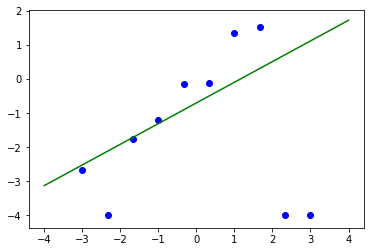

In [7]:
# フーバー回帰
x, y = generate_sample()
theta = iterative_reweighted_least_squares(x, y, method='huber', eta=1.)
visualize(x, y, theta)

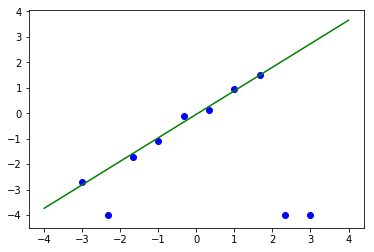

In [8]:
# フーバー回帰
x, y = generate_sample()
theta = iterative_reweighted_least_squares(x, y, method='tukey', eta=1.)
visualize(x, y, theta)

フーバー回帰はL1 lossとL2 lossの中間的なロスであるため外れ値に対してロバストではあるが，
いくらか外れ値の影響を受けるため直線がやや下に寄っている．  
テューキー回帰は損失関数に上限を定めているため大きな外れ値の影響をほとんど受けない．  